# УСТАНОВКА ПАКЕТОВ

In [ ]:
!pip install -q pymorphy2 # установка лемматизатора pymorphy2

In [ ]:
# Попробуем обойтись без переустановки
# !pip install tensorflow==2.3 # устанавливаем версию tf 2.3 и делаем restart runtime

# ИМПОРТ БИБЛИОТЕК

In [ ]:
import os
import re
import time

import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K  # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы
from tensorflow.keras import utils # Импортируем для работы с категориальными данными
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from google.colab import files
import matplotlib.pyplot as plt
from gensim.models import word2vec  # Импортируем gensim
import nltk # Natural language toolkit - Инструментарий естественного языка
from nltk.stem import WordNetLemmatizer  # Импортируем для работы с леммами
import pymorphy2  # Импортируем для работы с леммами

In [ ]:
nltk.download('wordnet')  # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
print(tensorflow.__version__)

2.6.0


## Монтируем диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# НАСТРОЙКИ

In [ ]:
DIR_ROOT = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста'
WINDOW_LEN = 256  # Длина скользящего окна
WINDOW_STEP = 30  # Шаг скользящего окна
EMBEDDING_SIZE = 100  # Число измерений вектор-пространства для каждого нашего слова 


# КЛАСС ДЛЯ РАБОТЫ С ТЕКСТОМ
**Теги:**

**`<s1>`** - Условия

**`<s2>`** - Запреты

**`<s3>`** - Цена

**`<s4>`** - Условия (относительно дат)

**`<s5>`** - Штрафы

**`<s6>`** - Адреса и местоположения

In [ ]:
class DanText:
  # --- НАСТРОЙКИ ---
  def __init__(self, dir_root, window_len, step, embedding_size):
    self.root_dir = dir_root
    self.window_len = window_len
    self.step = step
    self.embedding_size = embedding_size  

  # --- Чтение и обработка текста ---
  def read_text(self, file_name):
    with open(self.root_dir + '/files/contracts/' + file_name) as f:
      text = f.read()

    # Строки и символы, которые надо удалить из текста
    delete_list = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']

    for s in delete_list:
      text = text.replace(s, ' ')  # Заменяем на пробел, что бы не было слипания текста
      # Выискиваем дополнительные знаки в текстах посредством паттернов и определяем на что их заменять
      text = re.sub('[.:]', ' ', text)
      text = re.sub('<', ' <', text)
      text = re.sub('>', '> ', text)
      text = re.sub('\s{2,}', ' ', text)  # Удаляем 2 и более пробелов
      text = text.lower()

    return text

  # --- Конвертируем текст в список слов с начальной формой ---
  def text_to_words(self, text):
    morph = pymorphy2.MorphAnalyzer()  # Инициализируем объект
    words_list = text.split(' ')
    words_normal_list = [morph.parse(word)[0].normal_form for word in words_list]  # В нормальную форму
    return words_normal_list

  # --- Получаем список индексов ---
  # На основе нашего слова получаем список из 6 значений классов, например  [0, 1, 0, 1, 0, 0] 
  def get_x_y_data_list(self, contracts_seq, tag_start_index, tag_close_index):
    word_list = []  # Тут будет храниться список слов
    word_index_list = []  # Тут будут храниться индексы слов из всех договоров, без тегов
    tag_index_list = []  # Тут будет храниться соответствие тегам индекса слова

    for contract_seq in contracts_seq:  # Проходим по договору - листу последовательности слов
      tag_place_list = [0, 0, 0, 0, 0, 0]
      for word_index in contract_seq:
        if word_index in tag_start_index:  # Проверяем, если индекс слова соотвествует индексу одного из тегов
          place = np.argwhere(tag_start_index==word_index)  # np.argwhere - возвращает индексы ненулевых элементов массива. Запоминаем позицию тега в этом листе индексов
          tag_place_list[place[0][0]] = 1  # Открывающий тег - устанавливаем значение 1, пример place -> place [[2]]
        elif word_index in tag_close_index:  # Проверяем, если индекс слова соотвествует индексу одного из тегов
          place = np.argwhere(tag_close_index==word_index)  # np.argwhere - возвращает индексы ненулевых элементов массива. Запоминаем позицию тега в этом листе тегов
          tag_place_list[place[0][0]] = 0  # Закрывающий тег - 0, пример place -> place [[2]]
        else:
          tag_index_list.append(tag_place_list.copy())
          word_index_list.append(word_index)  # Добавляем индекс-слова в лист индексов

    return word_index_list, tag_index_list

  # --- Переводит индексы слов в слова ---
  def index_to_word_list(self, contracts_dic, x):
    reverse_word_map = dict(map(reversed, contracts_dic.items()))  # Берёт ключ и значение из словаря и меняет их местами
    text_decoded = [reverse_word_map.get(index) for index in x] # Положим их в лист
    return text_decoded

  # --- Скользящие окна ---
  def sliding_windows(self, words_indexs):
    batch_list = []
    window_num = 0
    while window_num*self.step + self.window_len < len(words_indexs):
      window_start = window_num*self.step
      window_end = window_start + self.window_len
      batch_list.append(words_indexs[window_start:window_end])
      window_num += 1
    return batch_list

  # Дополняем короткую фразу нулями
  def pad_zeros(self, phrase):
    while len(phrase) < self.window_len:  # Пока сущестующий размер меньше длины окна
      phrase.append([0] * self.embedding_size)  # Добавляем нули  
    if len(phrase) > self.window_len:  # В противном случае, если фраза больше чем длина окна
      phrase = phrase[:self.window_len]  # Обрезаем до длины окна
    return phrase

  # Получаем ембединги из окон текста
  def get_embeddings(self, model, x, y):
    embedding_list = []  # Лист будет содержать ембеддинг представление на каждый индекс
    tmp = []  # Временный список
    for text in x:  # Проходимся по каждому лист-тексту
      tmp = []
      for word in text:  # Проходимся по кажому слову лист-текста
        try:  # Если слово есть в word2vec, мы не получим ошибку
          tmp.append(model[word])
        except:  # В противном случае пропустим слово
          pass

      embedding_list.append(self.pad_zeros(tmp))
    temp = np.array(embedding_list)
    return np.array(embedding_list, dtype = np.float32), np.array(y)

# СОЗДАЁМ ДАННЫЕ

## Читаем договора в список

In [ ]:
DAN = DanText(DIR_ROOT, WINDOW_LEN, WINDOW_STEP, EMBEDDING_SIZE)

In [ ]:
print('Количество договоров:', len(os.listdir(DAN.root_dir + '/files/contracts')))
os.listdir(DAN.root_dir + '/files/contracts')[250:255]  # Выводим на экран название 5 договоров

Количество договоров: 432


['dogovor-ustupki-prav-payschika.txt',
 'dogovor-zaloga-privatizirovannoy-kvartiri.txt',
 'dogovor-zaloga-sobstvennosti-na-kvartirui-v-stroyaschemsya-dome (1).txt',
 'dogovor-zaloga-imuschestva.txt',
 'dogovor-zaloga-imuschestvennih-prav.txt']

In [ ]:
time_start = time.time()
contracts_list = []  # Список договоров
i = 0
for file_name in os.listdir(DAN.root_dir + '/files/contracts'):
  text = DAN.read_text(file_name)
  if text != '':
    contracts_list.append(text)

  if i % 50 == 0:
    print(f'{int(time.time() - time_start)}c, {i}')
  i += 1

print(len(contracts_list))

0c, 0
0c, 50
0c, 100
1c, 150
1c, 200
2c, 250
2c, 300
3c, 350
3c, 400
423


In [ ]:
print(contracts_list[4][0:1000])

 договор бартера г г в лице действующего на основании именуемый в дальнейшем сторона 1 с одной стороны и в лице действующего на основании именуемый в дальнейшем сторона 2 с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 предмет договора 1 1 <s1> сторона 1 принимает на себя обязательства поставить стороне 2 в количестве <s3> по цене на общую сумму рублей </s1> </s3> 1 2 <s1> сторона 2 принимает на себя обязательства принять и отгрузить по реквизитам стороны 1 в количестве <s3> по цене на общую сумму рублей </s1> </s3> 1 3 <s1> качество товара должно соответствовать </s1> 2 порядок поставки товара 2 1 <s1> товар передается в месте нахождения принимающей стороны </s1> с этого момента обязательство по поставке и передаче права собственности считается выполненным 2 2 <s3> доставка производится за счет </s3> 2 3 доставка производится 3 сроки поставки и передачи 3 1 <s1> <s4> сторона 1 обязуется поставить стороне 2 в срок до го

## Переводим в список слов
Приводим к начальной форме

In [ ]:
time_start = time.time()
contracts_words_list = []  # Список слов договоров
for i in range(len(contracts_list)):
  contracts_words_list.append(DAN.text_to_words(contracts_list[i]))

print(f'Число договоров: {len(contracts_words_list)}')
print(f'Время выполнения: {time.time() - time_start} c')

Число договоров: 423
Время выполнения: 207.4004065990448 c


In [ ]:
print('ПРИМЕР ТЕКСТА ДОГОВОРА:', contracts_list[0][:100])
print('ПРИМЕР ЛЕММ-ДОГОВОРА:', contracts_words_list[0][:10])

ПРИМЕР ТЕКСТА ДОГОВОРА:  договор безвозмездного хранения до востребования г г гражданин паспорт серия номер выдан проживающи
ПРИМЕР ЛЕММ-ДОГОВОРА: ['', 'договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт']


## Создаём словарь слов
Слово => индекс частотности

In [ ]:
tokenizer = Tokenizer(lower=True, filters = '', char_level=False)
tokenizer.fit_on_texts(contracts_words_list)
contracts_dic = {}  # Создаем пустой словарь

for item in tokenizer.word_index.items():  # Превращаем лист в словарь
  contracts_dic[item[0]] = item[1]  # Мы меняем местами элеметны кортежа

In [ ]:
print('Словарь все слов по их частотноти:') 
print(contracts_dic, '\n')
print('Длина словаря:', len(contracts_dic))

tag = '<s1>'
print('Индекс тега', tag, ':', contracts_dic[tag])

Словарь все слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'право': 24, 'работа': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'лицо': 35, 'имущество': 36, 'день': 37, 'действовать': 38, 'арендатор': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'п': 45, 'дальнейший': 46, 'работник': 47, 'который': 48, 'а': 49, 'обязательство': 50, 'страховой': 51, 'законодательство': 52, 'порядок': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'арендодатель': 57, 'свой': 58, 'счёт': 59, 'соответствие': 60, 'указанный': 61, 'именовать': 62, 'мочь': 63, 'из': 64, 'основание': 65, 'обязанность': 66, 'обязать': 67, 'исполнение': 68, 'один': 69, 'страховщик': 70, 'страхователь': 71, 'иной': 72, 'год': 73, 'до': 7

## Превращаем текст в последовательность индексов

In [ ]:
contracts_seq = tokenizer.texts_to_sequences(contracts_words_list)
print('Исходный текст', contracts_words_list[0:20])
print('В последовательности индексов', contracts_seq[0:20])

Исходный текст [['', 'договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', '<s1>', 'при', 'передача', 'вещь', 'поклажедатель', 'на', 'хранение', 'хранитель', 'сторона', 'подписывать'

## Список тегов
**`<s1>`** - Условия договора

**`<s2>`** - Запреты

**`<s3>`** - Стоимость

**`<s4>`** - Условия (относительно дат)

**`<s5>`** - Штрафы

**`<s6>`** - Адреса и местоположения

In [ ]:
tag_start_index_list = []
tag_close_index_list = []

for i in range(1, 7):
  tag_start = '<s' + str(i) + '>'  # Открывающий тег
  tag_close = '</s' + str(i) + '>'  # Закрывающий тег
  tag_start_index_list.append(contracts_dic[tag_start])  # Получаем инексы открывающих тегов из словря частотности
  tag_close_index_list.append(contracts_dic[tag_close])  # Получаем инексы закрывающих из словря частотности

tag_start_index = np.array(tag_start_index_list)
tag_close_index = np.array(tag_close_index_list)

classes_num = tag_start_index.shape[0]

print('Индексы открывающих тегов:', tag_start_index)
print('Индексы закрывающих тегов:', tag_close_index)
print('Количество классов:', classes_num)

Индексы открывающих тегов: [ 12 341  22  27 118 279]
Индексы закрывающих тегов: [ 13 352  23  28 119 273]
Количество классов: 6


## Создаём data_x, data_y
Каждый индекс (слово) из договора будет соответсвовать вектору, чьи элементы соотвествуют категориям тегов

In [ ]:
d_x, d_y = DAN.get_x_y_data_list(contracts_seq, tag_start_index, tag_close_index)

In [ ]:
print(len(d_x))
print(len(d_y))

422294
422294


In [ ]:
text_decoded = DAN.index_to_word_list(contracts_dic, d_x)  # Чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов

In [ ]:
print('Посмотрим на исходные слова: ', contracts_words_list[0][50:80])
print('Сдекодированые слова:', text_decoded[50:80])

Посмотрим на исходные слова:  ['нижеследующий', '1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение']
Сдекодированые слова: ['нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий']


# СКОЛЬЗЯЩИЕ ОКНА

In [ ]:
data_x = DAN.sliding_windows(text_decoded)
data_y = DAN.sliding_windows(d_y)

print(len(data_x), len(data_y))
print('data_x:', data_x[0:10])
print('data_y:', data_y[0:10])

14068 14068
data_x: [['', 'договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'поклажедатель', 'на', 'хранение', 'хранитель', 'сторона', 'подписывать', 'акт', 'приём', 'п

## Учебная и тестовая выборка

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=12)

print('train', len(train_x), len(train_y))
print('test', len(test_x), len(test_y))

train 12661 12661
test 1407 1407


# Word2Vec
Переводим каждое слово с помощью word2vec в вектор длинной 300

In [ ]:
# Подаём лист листов слов в word2vec для обучающей выборке
# size = EMBEDDING_SIZE - Размер ембеддинга
# window = 10 -  минимальное расстояния между эмбеддинг словами
# min_count = 1 - Игнорируем все слова с частотой меньше чем 1
# workers = 10 -  Число потоков на обучение эмбеддинга
# iter = 20 -  Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5 -  Число слов в "словарном запасе" word2vec
time_start = time.time()

x = train_x + test_x

model_GENSIM = word2vec.Word2Vec(x, size=EMBEDDING_SIZE, window=10, min_count=1, workers=10, iter=10, max_vocab_size=1e5)
print('Обучение GENSIM модели заняло: ', round(time.time() - time_start, 2), 'с.')

Обучение GENSIM модели заняло:  46.54 с.


In [ ]:
GENSIM_train_x, GENSIM_train_y = DAN.get_embeddings(model_GENSIM, train_x, train_y)
GENSIM_test_x, GENSIM_test_y = DAN.get_embeddings(model_GENSIM, test_x, test_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
print('Размерности train:', GENSIM_train_x.shape, GENSIM_train_y.shape)
print('Размерности test:', GENSIM_test_x.shape, GENSIM_test_y.shape)

Размерности train: (12661, 256, 100) (12661, 256, 6)
Размерности test: (1407, 256, 100) (1407, 256, 6)


In [ ]:
model_GENSIM['договор']  # Пример превращения слова в вектор при помощи GENSIM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.9459449 , -4.235268  , -0.41245553,  0.9640877 , -1.3190135 ,
       -0.9374889 , -0.36282715,  1.9525498 ,  1.3417195 ,  1.7475933 ,
       -0.35423705, -2.4054291 , -1.2492937 ,  0.3485503 ,  0.49038872,
       -0.32689124,  0.14312182, -1.4100987 , -0.6968559 , -0.34515768,
       -2.5991273 ,  2.2922204 ,  1.9519233 ,  1.4287835 ,  3.3610053 ,
        0.8428831 , -1.4707072 ,  0.47721118, -0.69887686, -2.896539  ,
       -2.2354    ,  0.06294575,  1.104164  ,  0.9273564 ,  2.9627304 ,
       -0.480208  ,  2.8243272 ,  2.771807  , -0.3543674 , -2.2057939 ,
        0.37613982,  2.5028687 ,  0.3103623 , -1.6007817 ,  1.0314412 ,
        1.9266835 ,  3.2232327 ,  1.8221195 , -3.8739693 ,  0.497675  ,
       -0.77563626,  2.4334993 , -1.0219878 ,  0.22509633,  1.807936  ,
        4.1041903 , -0.9300905 , -0.87488866, -0.6814836 ,  1.5089247 ,
       -0.29334173,  0.11979339, -2.4998255 ,  4.098181  , -0.5119591 ,
        5.526683  , -2.6421304 ,  0.5900351 ,  0.14877601,  1.11

# МОДЕЛЬ

## Класс модели

In [ ]:
class DanModel():
  def __init__(self, classes_num, window_len, window_step, embedding_size):
    self.classes_num = classes_num
    self.window_len = window_len
    self.window_step = window_step
    self.embedding_size = embedding_size

  # Метрика точночти - dice коэффициент - площадь пересечения / площадь объединения
  def dice_coef(self, y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

  # Функция, что создаёт линейную свёрточную сеть
  def create_Conv1d(self): 
    x_input = Input((self.window_len, self.embedding_size)) 
    x = Conv1D(16, 3, padding='same', activation='relu')(x_input)
    x = Conv1D(16, 3, padding='same', activation='relu')(x)
    x = Conv1D(16, 3,padding='same', activation='relu')(x) 
    x = Conv1D(self.classes_num, 3, padding='same', activation='sigmoid')(x)
    model = Model(x_input, x)
    model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=[self.dice_coef])
    return model

  # Создаёт PSPnet
  def create_PSPnet(self, conv_size=64):
    x_input = Input((self.window_len, self.embedding_size)) 

    # Блок 1
    x = Conv1D(conv_size, 3, padding='same')(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = MaxPooling1D(32)(x)
    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    # Разворачиваем свёртку

    x_mp_2 = Conv1DTranspose(conv_size, 2, strides=2)(x_mp_2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(conv_size, 4, strides=4)(x_mp_4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(conv_size, 8, strides=8)(x_mp_8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(conv_size, 16, strides=16)(x_mp_16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(conv_size, 32, strides=32)(x_mp_32)
    x_mp_32 = Activation('relu')(x_mp_32)

    conc = concatenate([x_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(conc)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(self.classes_num, 3, activation='sigmoid', padding='same')(fin)

    model = Model(x_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001), loss='categorical_crossentropy', metrics=[self.dice_coef])
    
    return model

  # Создаёт Unet
  def create_Unet(self, k=1):
    x_input = Input((self.window_len, self.embedding_size)) 

    # Блок 1
    x = Conv1D(64*k, 3, padding='same')(x_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64*k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    x_1 = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(x_1)
    x = Conv1D(128*k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x_2 = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(x_2)
    x = Conv1D(256*k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x_3 = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(x_3)
    x = Conv1D(512*k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512*k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    x_4 = Activation('relu')(x)
    x = x_4 

    # UP 2
    x = Conv1DTranspose(256*k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, x_3]) 
    x = Conv1D(256*k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(128*k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, x_2])
    x = Conv1D(128*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(64*k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, x_1])
    x = Conv1D(64*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64*k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(self.classes_num, 3, activation='sigmoid', padding='same')(x)

    model = Model(x_input, x) 

    model = Model(x_input, x)
    model.compile(optimizer=Adam(0.0025), loss='categorical_crossentropy', metrics=[self.dice_coef])
  
    return model

  # Проверка модели на тестовых данных
  def check_model(self, model, x, y, tags, value):
    correct_list = np.array([0] * self.classes_num) # Инициализируем массив правильных ответов (пока нули)
    incorrect_list =  np.array([0] * self.classes_num)  # Инициализируем массив неправильных ответов в нули

    pred = model.predict(x)
    pred[pred < value] = 0
    pred[pred > value] = 1

    for element in range(y.shape[0]):  # Проходим по всем примерам в батче
      for word in range(y.shape[1]):  # Проходим по каждому слову
        for category in range(y.shape[2]):  # Проходим по каждой категории в слове
          if pred[element][word][category] == y[element][word][category]:  # Если предсказанное значение совпадает с истинным:
            correct_list[category] += 1  # Отмечаем, что мы правильно предсказали класс объекта
          else:  # Если предсказанное значение НЕ совпадает с истенным:
            incorrect_list[category] += 1  # Отмечаем, что мы не правильно предсказали класс объекта
        
    # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
    for i in range(self.classes_num):
      print(f'Сеть распознала категорию  {tags[i]} с точностью в {round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)}%' )

    total = round(100*np.mean(correct_list/(correct_list + incorrect_list)), 2) 
    print(f'Средняя точность {total}%')

In [ ]:
MODEL = DanModel(classes_num, WINDOW_LEN, WINDOW_STEP, EMBEDDING_SIZE)

## Создаём Conv1d

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 100)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 16)           4816      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 6)            294       
Total params: 6,678
Trainable params: 6,678
Non-trainable params: 0
_________________________________________________________________


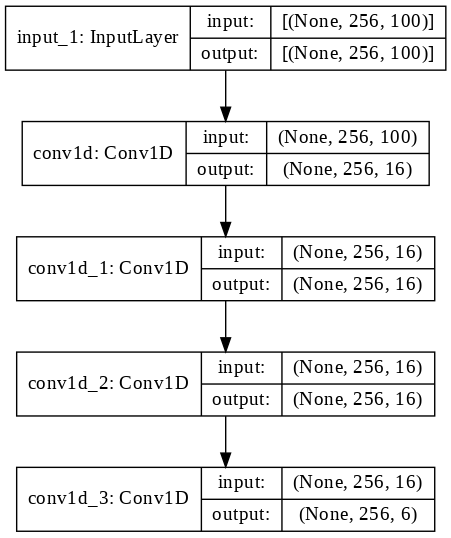

In [ ]:
model_conv1d = MODEL.create_Conv1d()
model_conv1d.summary() # Выводим саммери
plot_model(model_conv1d, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=100)

In [ ]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join(DIR_ROOT, 'Conv1d.h5'), 
    monitor='val_dice_coef',
    mode='max',
    verbose=1, 
    save_best_only=True
)
history = model_conv1d.fit(GENSIM_train_x, GENSIM_train_y, epochs=100, batch_size=100, validation_data=(GENSIM_test_x, GENSIM_test_y), callbacks=[checkpointer])

Epoch 1/100
127/127 [==============================] - 2s 16ms/step - loss: 2.0356 - dice_coef: 0.1418 - val_loss: 2.0349 - val_dice_coef: 0.1450

Epoch 00001: val_dice_coef improved from -inf to 0.14496, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/Conv1d.h5
Epoch 2/100
127/127 [==============================] - 2s 16ms/step - loss: 2.0008 - dice_coef: 0.1439 - val_loss: 2.0001 - val_dice_coef: 0.1469

Epoch 00002: val_dice_coef improved from 0.14496 to 0.14691, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/Conv1d.h5
Epoch 3/100
127/127 [==============================] - 2s 16ms/step - loss: 1.9666 - dice_coef: 0.1459 - val_loss: 1.9660 - val_dice_coef: 0.1489

Epoch 00003: val_dice_coef improved from 0.14691 to 0.14889, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/Conv1d.h5
Epoch 4/100
127/127 [==============================] - 2s 16ms/step - loss: 

[]

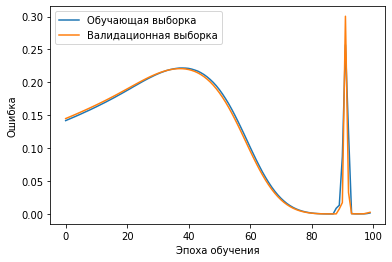

In [ ]:
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Валидационная выборка')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.plot()

## Создаём PSPnet

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 100)]   0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 256, 256)     77056       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256)     1024        conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256)     0           batch_normalization[0][0]        
____________________________________________________________________________________________

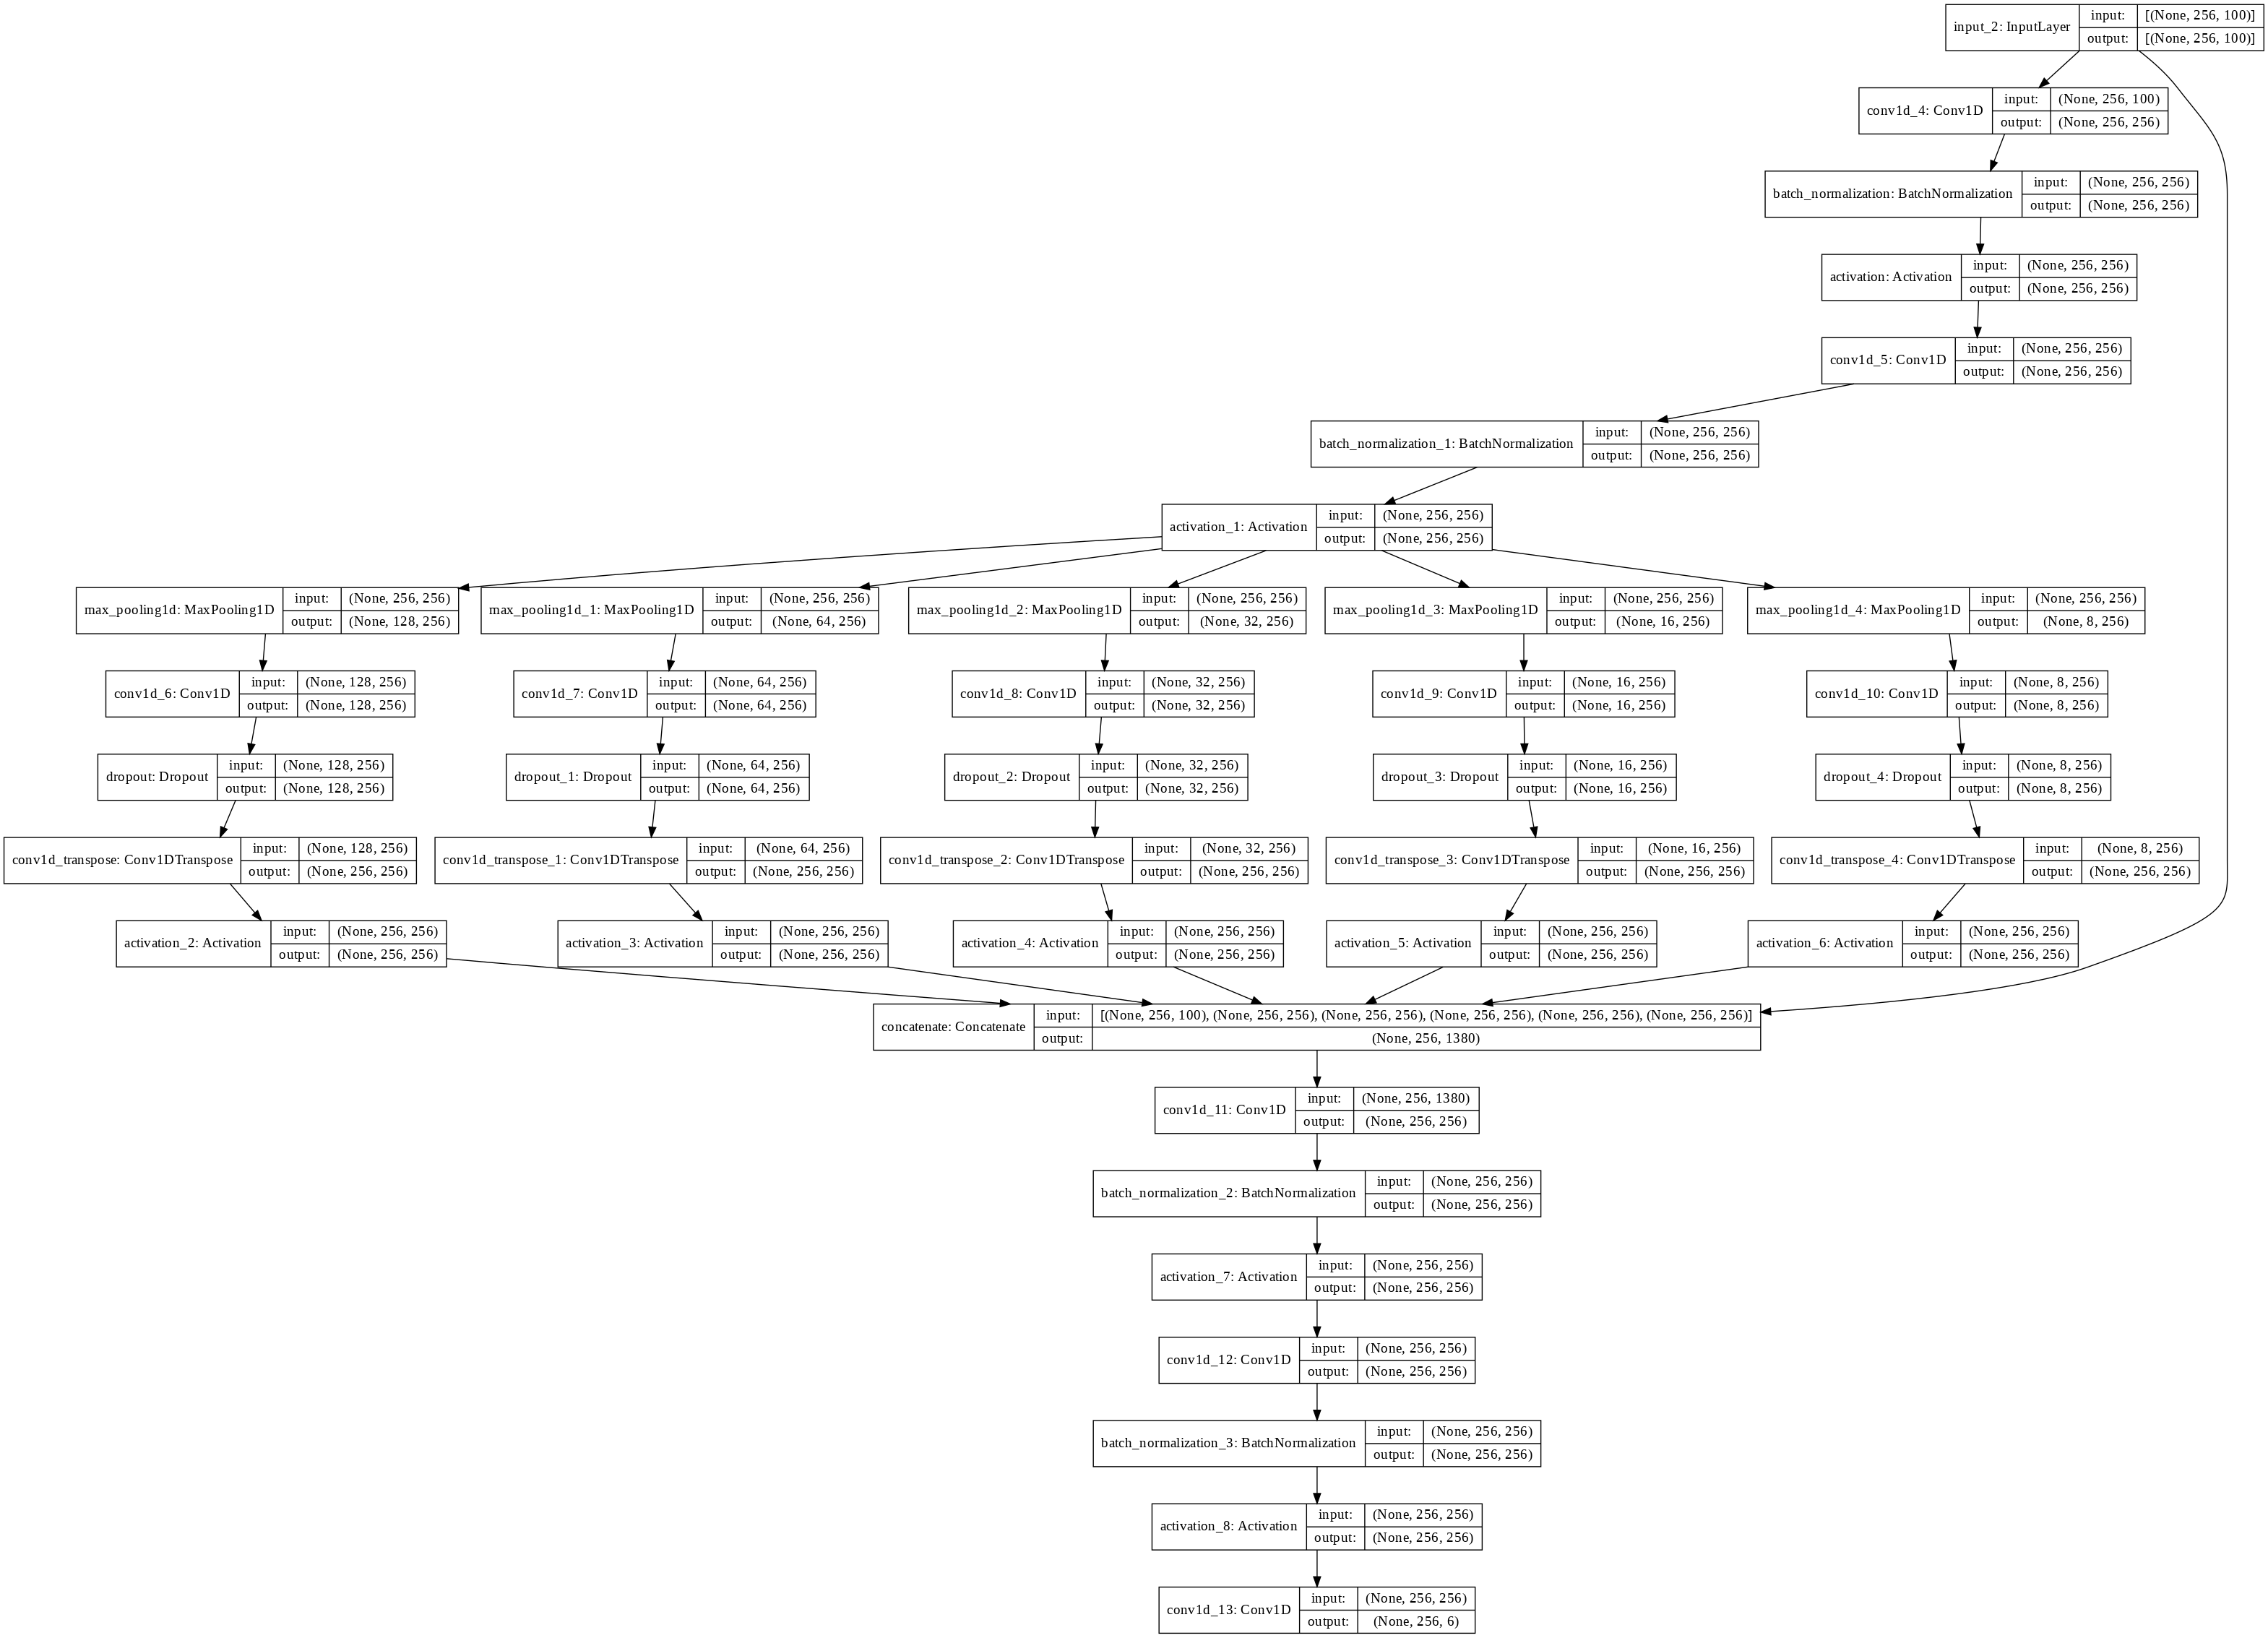

In [ ]:
model_PSPnet = MODEL.create_PSPnet(conv_size=256)
model_PSPnet.summary() # Выводим саммери
plot_model(model_PSPnet, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=100)

In [ ]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join(DIR_ROOT, 'PSPnet.h5'), 
    monitor='val_dice_coef',
    mode='max',
    verbose=1, 
    save_best_only=True
)
history = model_PSPnet.fit(GENSIM_train_x, GENSIM_train_y, validation_data = (GENSIM_test_x, GENSIM_test_y), epochs=50, batch_size=64, callbacks=[checkpointer])

Epoch 1/50
198/198 [==============================] - 52s 245ms/step - loss: 1.5964 - dice_coef: 0.1822 - val_loss: 1.5274 - val_dice_coef: 0.1887

Epoch 00001: val_dice_coef improved from -inf to 0.18866, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/PSPnet.h5
Epoch 2/50
198/198 [==============================] - 46s 234ms/step - loss: 1.4893 - dice_coef: 0.1939 - val_loss: 1.4668 - val_dice_coef: 0.1999

Epoch 00002: val_dice_coef improved from 0.18866 to 0.19986, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/PSPnet.h5
Epoch 3/50
198/198 [==============================] - 46s 233ms/step - loss: 1.3875 - dice_coef: 0.2065 - val_loss: 1.3701 - val_dice_coef: 0.2132

Epoch 00003: val_dice_coef improved from 0.19986 to 0.21325, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/PSPnet.h5
Epoch 4/50
198/198 [==============================] - 46s 233ms/step - lo

[]

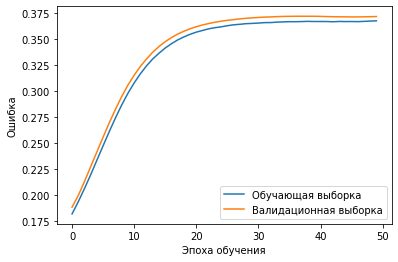

In [ ]:
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Валидационная выборка')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.plot()

## Создаём Unet

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 100)]   0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 256, 64)      19264       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 256, 64)      256         conv1d_14[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 256, 64)      0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

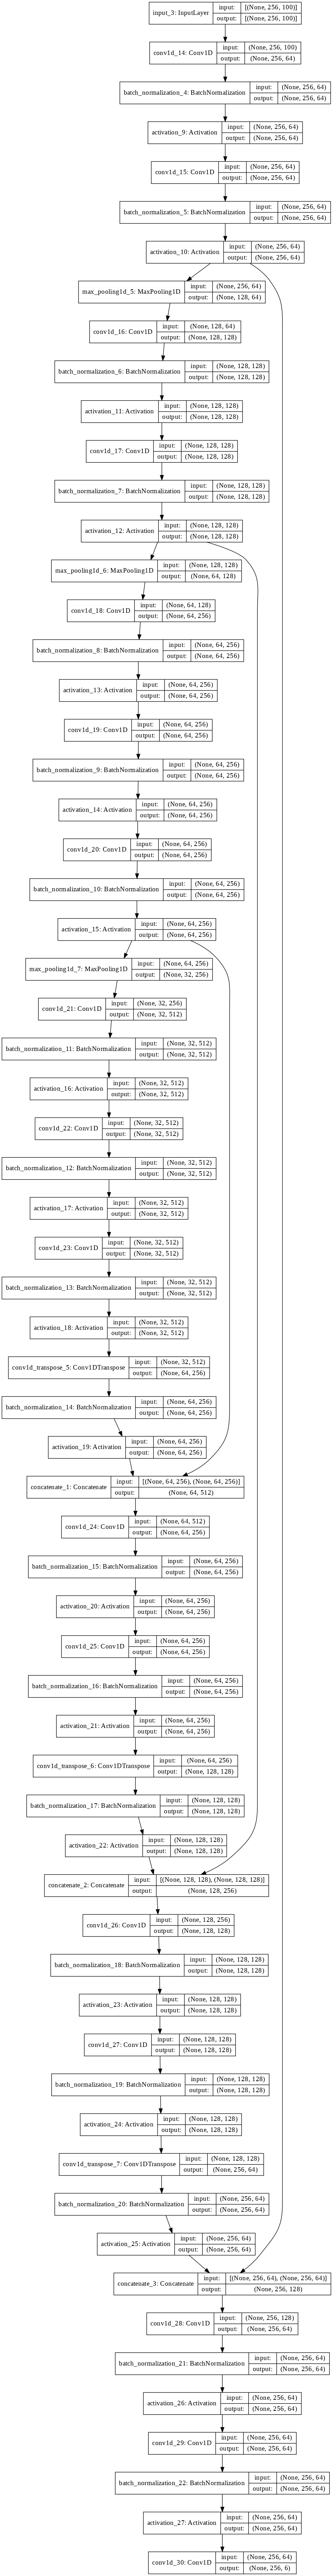

In [ ]:
model_Unet = MODEL.create_Unet()
model_Unet.summary() # Выводим саммери
plot_model(model_Unet, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=100)

In [ ]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join(DIR_ROOT, 'Unet.h5'), 
    monitor='val_dice_coef',
    mode='max',
    verbose=1, 
    save_best_only=True
)
history = model_Unet.fit(GENSIM_train_x, GENSIM_train_y, validation_data = (GENSIM_test_x, GENSIM_test_y), epochs=50, batch_size=64, callbacks=[checkpointer])

Epoch 1/50
198/198 [==============================] - 34s 139ms/step - loss: 1.1920 - dice_coef: 0.3704 - val_loss: 22.9271 - val_dice_coef: 0.2748

Epoch 00001: val_dice_coef improved from -inf to 0.27475, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/Unet.h5
Epoch 2/50
198/198 [==============================] - 26s 132ms/step - loss: 2.1675 - dice_coef: 0.3271 - val_loss: 4.6385 - val_dice_coef: 0.3037

Epoch 00002: val_dice_coef improved from 0.27475 to 0.30369, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/Unet.h5
Epoch 3/50
198/198 [==============================] - 26s 132ms/step - loss: 2.7261 - dice_coef: 0.3262 - val_loss: 9.9726 - val_dice_coef: 0.3186

Epoch 00003: val_dice_coef improved from 0.30369 to 0.31864, saving model to /content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/18. Сегментация текста/Unet.h5
Epoch 4/50
198/198 [==============================] - 26s 132ms/step - loss: 4

[]

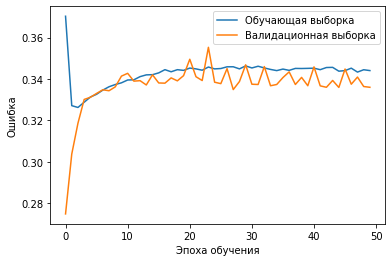

In [ ]:
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Валидационная выборка')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.plot()

## ПРОВЕРКА РАБОТЫ

In [ ]:
print('Размер test_x:', GENSIM_test_x.shape)
print('Размер test_y:', GENSIM_test_y.shape)

Размер test_x: (1407, 256, 100)
Размер test_y: (1407, 256, 6)


In [ ]:
# ТЕГИ
# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']

## Conv1D

In [ ]:
model_conv1d.load_weights(os.path.join(DIR_ROOT, 'Conv1d.h5'))
MODEL.check_model(model_conv1d, GENSIM_test_x, GENSIM_test_y, tags, 0.5)

Сеть распознала категорию  S1 с точностью в 55.11%
Сеть распознала категорию  S2 с точностью в 97.95%
Сеть распознала категорию  S3 с точностью в 83.92%
Сеть распознала категорию  S4 с точностью в 78.53%
Сеть распознала категорию  S5 с точностью в 93.69%
Сеть распознала категорию  S6 с точностью в 99.02%
Средняя точность 84.7%


## PSPnet

In [ ]:
model_PSPnet.load_weights(os.path.join(DIR_ROOT, 'PSPnet.h5'))
MODEL.check_model(model_PSPnet, GENSIM_test_x, GENSIM_test_y, tags, 0.5)

Сеть распознала категорию  S1 с точностью в 59.12%
Сеть распознала категорию  S2 с точностью в 98.6%
Сеть распознала категорию  S3 с точностью в 67.08%
Сеть распознала категорию  S4 с точностью в 72.12%
Сеть распознала категорию  S5 с точностью в 80.19%
Сеть распознала категорию  S6 с точностью в 99.02%
Средняя точность 79.36%


## Unet

In [ ]:
model_Unet.load_weights(os.path.join(DIR_ROOT, 'Unet.h5'))
MODEL.check_model(model_Unet, GENSIM_test_x, GENSIM_test_y, tags, 0.5)

Сеть распознала категорию  S1 с точностью в 76.64%
Сеть распознала категорию  S2 с точностью в 67.84%
Сеть распознала категорию  S3 с точностью в 66.68%
Сеть распознала категорию  S4 с точностью в 63.18%
Сеть распознала категорию  S5 с точностью в 61.37%
Сеть распознала категорию  S6 с точностью в 67.42%
Средняя точность 67.19%
